In [1]:
%load_ext watermark


In [2]:
import itertools as it
import numpy as np
import os

from IPython.display import display
import matplotlib as mpl
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-01T03:24:41.232301+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1029-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.10.0
teeplot   : 1.4.2
numpy     : 2.1.2
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-01-cpp-bench-memory-native-tilted"
)
teeplot_subdir


'2025-06-30-cpp-bench-memory-tilted'

## Prep Data


In [5]:
algo_names = {
    "dstream.circular_algo": "simple ringbuf",
    "control_throwaway_algo": "no-operation",
    "dstream.tilted_algo": "extended ringbuf",
    "dstream_tilted_algo": "extended ringbuf LUT",
    "doubling_tilted_algo": "naive doubling",
    "zhao_tilted_algo": "pyrimidal bucket",
    "zhao_tilted_full_algo": "saturating bucket",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/cbqpx/download"),
    ],
)
print("\n".join(df["algo_name"].unique().to_list()))
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
        pl.col("num_items") == 1_000_000,
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        ),
        num_retained=(
            pl.when(pl.col("algo_name") == "dstream_tilted_algo")
            .then(pl.col("num_sites"))
            .when(pl.col("algo_name") == "doubling_tilted_algo")
            .then(pl.col("num_sites") * 0.75)
            .when(pl.col("algo_name") == "zhao_tilted_algo")
            .then(19)
            .when(pl.col("algo_name") == "zhao_tilted_full_algo")
            .then(pl.col("num_sites"))
            .otherwise(pl.col("num_sites"))
        )
    )
    .with_columns(
        (pl.col("memory_bytes") / pl.col("num_retained")).alias("bytes per item"),
    )
    .with_columns(
        (8 * pl.col("memory_bytes") / pl.col("num_retained")).alias("bits per item"),
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


dstream_stretched_algo
dstream.compressing_algo
doubling_tilted_algo
dstream.tilted_algo
control_throwaway_algo
dstream.steady_algo
zhao_tilted_full_algo
zhao_tilted_algo
doubling_steady_algo
dstream.stretched_algo
dstream_tilted_algo
zhao_steady_algo
dstream.circular_algo


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,str
"""count""","""1120""","""1120""","""1120""",1120.0,1120.0,1120.0,1120.0,1120.0,"""1120""",1120.0,1120.0,1120.0,"""1120"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,2106.571429,1e6,1360.0,4.5,5.660586,null,1119.857143,2.280555,18.244439,null
"""std""",null,null,null,3978.521282,0.0,1620.679234,2.873564,23.588329,null,1517.611823,1.710403,13.683223,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,1e6,64.0,0.0,0.080037,"""extended ringbuf""",19.0,0.125977,1.0078125,"""bit"""
"""25%""",null,null,null,119.0,1e6,256.0,2.0,0.196042,null,64.0,1.003906,8.03125,null
"""50%""",null,null,null,320.0,1e6,1024.0,5.0,1.133214,null,256.0,2.015625,16.125,null
"""75%""",null,null,null,2052.0,1e6,1024.0,7.0,2.020015,null,1024.0,4.000977,32.007812,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,9.0,204.034583,"""simple ringbuf""",4096.0,6.263158,50.105263,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,str
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,0,0.080503,"""no-operation""",4096.0,4.000977,32.007812,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,1,0.080506,"""no-operation""",4096.0,4.000977,32.007812,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,2,0.080556,"""no-operation""",4096.0,4.000977,32.007812,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,3,0.080556,"""no-operation""",4096.0,4.000977,32.007812,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,4,0.080506,"""no-operation""",4096.0,4.000977,32.007812,"""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,3.017475,"""saturating bucket""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,3.017482,"""saturating bucket""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,3.017487,"""saturating bucket""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,3.017428,"""saturating bucket""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,3.017484,"""saturating bucket""",64.0,1.125,9.0,"""bit"""


In [6]:
assert (df.group_by(
    ["num_items", "num_sites", "algorithm", "data type"],
).agg(
    pl.col("memory_bytes").n_unique(),
)["memory_bytes"] == 1).all()


In [7]:
hue_order = [
    "extended ringbuf",
    "saturating bucket",
    "pyrimidal bucket",
    # "extended ringbuf LUT",
    # "simple ringbuf",
    "naive doubling",
]


In [8]:
palette = sns.color_palette("deep")


## Plot


## Memory Use


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


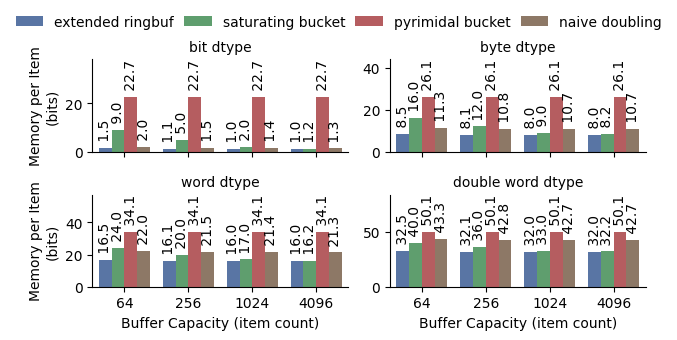

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


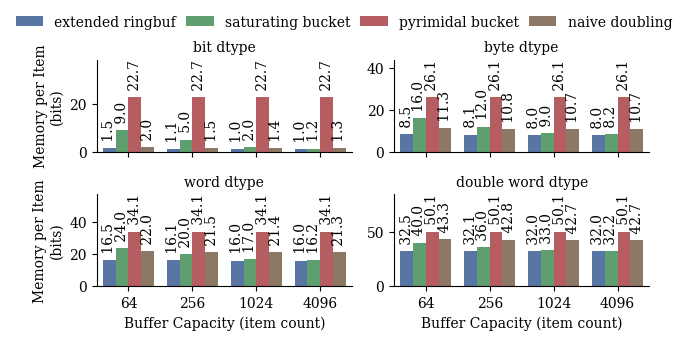

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


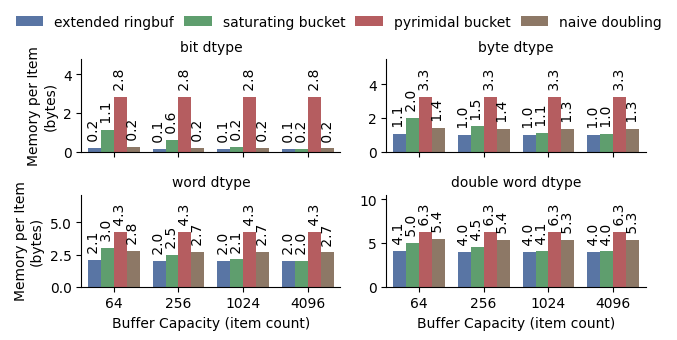

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+hue=algorithm+kind=bar+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


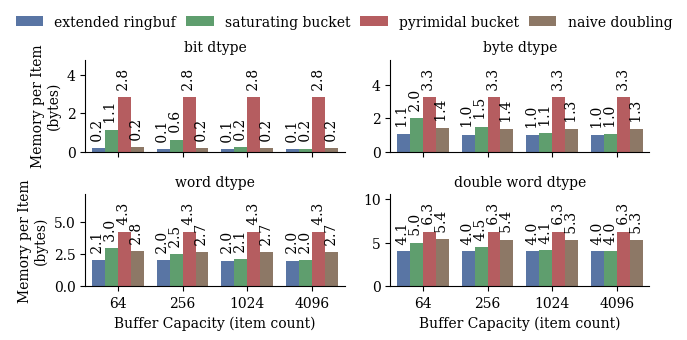

In [9]:
for unit, rc in it.product(["bits", "bytes"], [{}, {"font.family": "serif"}]):
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y=f"{unit} per item",
            hue="algorithm",
            hue_order=hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette=np.array(
                palette,
            )[[0, 2, 3, 5]],
            sharey=False,
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels(f"Memory per Item\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for row, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.6)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.1f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
